In [6]:
# Basic Libraries 📚
# --------------------------------------
import numpy as np
import pandas as pd


# Plot library
# --------------------------------------
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import seaborn as sns


# NLP
# --------------------------------------
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

from textblob import Word, TextBlob
from wordcloud import WordCloud  # visualization of words
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Metrics
# --------------------------------------
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder

# Customize to Remove Warnings and Better Observation 🔧
# --------------------------------------------------------
# from warnings import filterwarnings
# filterwarnings('ignore')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 200)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [7]:
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/guillaume/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/guillaume/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/guillaume/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/guillaume/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/guillaume/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloadi

True

In [8]:
# df = pd.read_csv("/home/guillaume/nlp_sentiment_detection/data/product_reviews/books_data.csv")
df = pd.read_csv("/home/guillaume/nlp_sentiment_detection/data/product_reviews/Books_rating.csv", 
                  nrows = 1000)
df = df.rename(columns = {"review/text" : "review"})

In [9]:
df["review"] = df["review"].str.lower()

In [10]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text_url = re.sub(r'http\S+', '', text)
    stop_text = " ".join([x for x in text_url.split() if x not in stopwords.words("english")])
    punctuation_text = re.sub('[^\w\s]', '', stop_text)
    lem_words = [lemmatizer.lemmatize(token) for token in punctuation_text.split()]
    return " ".join([x for x in lem_words if x not in stopwords.words("english")])
text = "Hello guys, http://www.salut.com how 'bean' you?"
preprocess_text(text)

'Hello guy bean'

In [11]:
df["review_clean"] = df["review"].map(preprocess_text)

In [12]:
count_words = df["review_clean"].apply(lambda x: pd.Series(x.split(" ")).value_counts()).sum(axis=0).reset_index()
count_words = count_words.rename(columns = {"index" : "word", 0 : "count"})
count_words.sort_values(by="count", ascending=False)[:60]

,word,count
9,book,2260.0
152,read,642.0
2,one,553.0
518,story,351.0
1,like,327.0
1065,love,319.0
276,would,303.0
79,great,303.0
1058,character,285.0
56,time,258.0


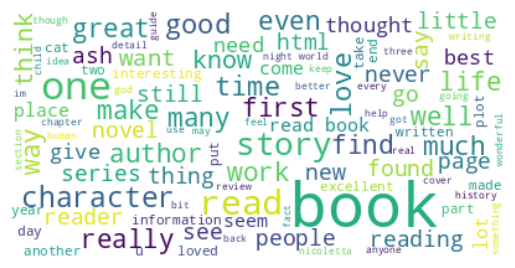

In [13]:
text = " ".join(i for i in df.review_clean) 
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
df = df[df["review/score"]!=3]
df["score"] = df["review/score"].map(lambda x: 1 if x>3 else 0)

In [15]:
words_to_keep = count_words[count_words["count"]>=10]["word"].tolist()
len(words_to_keep)

1201

In [16]:
def keep_words(text, words_to_keep = words_to_keep):
    words_to_keep = [token for token in text.split() if token in words_to_keep]
    return " ".join(words_to_keep)
text = "you book"
keep_words(text, words_to_keep)

'book'

In [17]:
df["review_top_words"] = df["review"].map(keep_words)

In [18]:
vectoriser = CountVectorizer()
X = vectoriser.fit_transform(df["review_clean"])
X.toarray().shape

(920, 11173)

In [19]:
sia = SentimentIntensityAnalyzer()
df["polarity_score"] = df["review_top_words"].map(lambda x: 1 if sia.polarity_scores(x)["compound"]>0 else -1) 

In [20]:
vectoriser = CountVectorizer()
X = vectoriser.fit_transform(df["review_top_words"])

<Axes: >

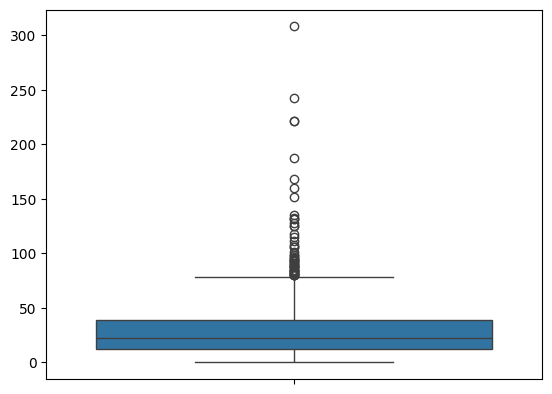

In [21]:
sns.boxplot(data= X.toarray().sum(axis=1))

In [22]:
# import spacy

# nlp = spacy.load("en_core_web_sm")
# doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
# for token in doc:
#     print(token.text, token.pos_, token.dep_)

In [26]:
# import os
# import shutil

# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer

from keras.utils import to_categorical
from keras import models
from keras import layers

# tf.get_logger().setLevel('ERROR')

In [27]:
input_dim = X.shape[1]

In [28]:
model = models.Sequential()
model.add(layers.Dense(50, activation = "relu", input_shape=(input_dim, )))
# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

/home/guillaume/nlp_sentiment_detection/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │        58,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,651 (248.64 KB)

 Trainable params: 63,651 (248.64 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
data_x = X.toarray()
y = df["score"].values

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train_X, X_test, train_y, y_test = train_test_split(data_x, y, test_size = 0.2, shuffle = True, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size = 0.2, shuffle = True, random_state=4)

In [32]:
model.compile(
optimizer = "adam",
loss = "binary_crossentropy",
metrics = ["accuracy"]
)

In [34]:
results = model.fit(
X_train, y_train,
epochs= 100,
batch_size = 32,
validation_data = (X_val, y_val)
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9870 - loss: 0.0467 - val_accuracy: 0.8986 - val_loss: 0.5856
Epoch 2/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0193